In [29]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from collections import defaultdict

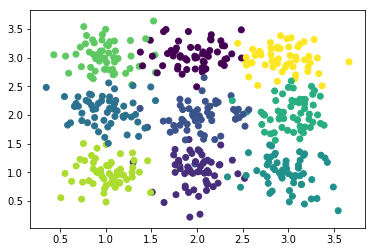

In [135]:
n_centers = 9
n_runs = 5
n_init_range = np.array([1, 5, 10, 15, 20])


centers = np.empty([n_centers, 2])

# centers[0][0], centers[0][1] = 1, 1
# centers[1][0], centers[1][1] = 2, 1
# centers[2][0], centers[2][1] = 3, 1
# ###
# centers[3][0], centers[3][1] = 1, 2
# centers[4][0], centers[4][1] = 2, 2
# centers[5][0], centers[5][1] = 3, 2
# ###
# centers[6][0], centers[6][1] = 1, 3
# centers[7][0], centers[7][1] = 2,3
# centers[8][0], centers[8][1] = 3,3
X, Y = sklearn.datasets.make_blobs(
    n_samples=500,
    n_features=3,
    centers=centers,
    cluster_std=0.25)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

min_X, max_X, min_Y, max_Y = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()

limits = (min_X, max_X, min_Y, max_Y)

In [136]:
def generate_random_init(init_algorithm, n_clusters, limits, X):
    if init_algorithm == 'random':
        rand_x = np.random.uniform(limits[0], limits[1], n_clusters)
        rand_y = np.random.uniform(limits[2], limits[3], n_clusters)
        return np.dstack((rand_x, rand_y))[0]
    if init_algorithm == 'random_partition':
        number_of_elements = len((X[:, 0]))
        rand_clusters = np.random.random_integers(0, n_clusters-1, size = number_of_elements)
        elems_by_clusters = {}
        for idx, element in enumerate(rand_clusters):
            if element in elems_by_clusters:
                elems_by_clusters[element].append(X[idx])
            else:
                elems_by_clusters[element] = [X[idx]]
        avg_for_cluster = []
        for key, value in elems_by_clusters.items():
            stacked = np.stack(value)
            meaned = np.mean(stacked, axis=0)
            avg_for_cluster.append((key, meaned))
        sorted_list = sorted(avg_for_cluster, key = lambda tup: tup[0])
        result = []
        for element in sorted_list:
            result.append(element[1])
        return np.array(result)
    else:
        raise NameError(init_algorithm)

In [22]:
rand = generate_random_init('random_partition', 9, limits, X)

/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead
  


/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=5
  return_n_iter=True)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=15
  return_n_iter=True)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=20
  return_n_iter=True)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launc

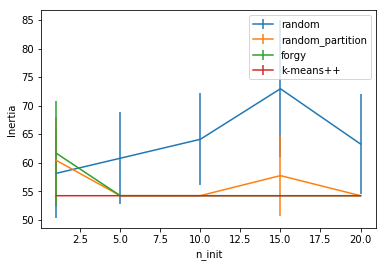

In [138]:
plots_inertia = []
plots_ch = []
legends = ['random', 'random_partition', 'forgy', 'k-means++']
silhouette_results = defaultdict(list)
partial_results = defaultdict(list)
iterations = [1, 5, 15]

for init_algorithm in ['random', 'random_partition', 'forgy', 'k-means++']:
    inertia = np.empty((len(n_init_range), n_runs))
    calinski_harabaz = np.empty((len(n_init_range), n_runs))
    for run_id in range(n_runs):
        for i, n_init in enumerate(n_init_range):
            if run_id != n_runs-1: # runs normally without silhouerette score
                if init_algorithm == 'forgy':
                    kmeans = KMeans(n_clusters=9, init='random', random_state=run_id, n_init=n_init).fit(X)
                elif init_algorithm == 'k-means++':
                    kmeans = KMeans(n_clusters=9, init='k-means++', random_state=run_id, n_init=n_init).fit(X)
                else:
                    random_init = generate_random_init(init_algorithm, 9, limits, X)
                    kmeans = KMeans(n_clusters=9, init=random_init, random_state=run_id, n_init=n_init).fit(X)
                labels = kmeans.labels_
                c_h = metrics.calinski_harabaz_score(X, labels)
                calinski_harabaz[i, run_id] = c_h
                inertia[i, run_id] = kmeans.inertia_
            elif run_id == n_runs-1: # run with calculacting silhouerette score
                    for iteration_idx, iteration in enumerate(iterations):
                        if init_algorithm == 'forgy':
                            kmeans = KMeans(n_clusters=9, init='random', random_state=run_id, n_init=n_init, max_iter=iteration).fit(X)
                        elif init_algorithm == 'k-means++':
                            kmeans = KMeans(n_clusters=9, init='k-means++', random_state=run_id, n_init=n_init, max_iter=iteration).fit(X)
                        else:
                            random_init = generate_random_init(init_algorithm, 9, limits, X)
                            kmeans = KMeans(n_clusters=9, init=random_init, random_state=run_id, n_init=n_init, max_iter=iteration).fit(X)
                        if n_init == 20:
                            silhouette_results[init_algorithm].append(metrics.silhouette_score(X, kmeans.labels_))
                            partial_results[init_algorithm].append(kmeans.labels_)
                        if iteration_idx == len(iterations)-1:
                            # last iteration
                            labels = kmeans.labels_
                            c_h = metrics.calinski_harabaz_score(X, labels)
                            calinski_harabaz[i, run_id] = c_h
                            inertia[i, run_id] = kmeans.inertia_
                    
    # resolve that, when to add this
    p_inertia = plt.errorbar(n_init_range, inertia.mean(axis=1), inertia.std(axis=1))
    plots_inertia.append(p_inertia)
        
    #p_ch = plt.errorbar(n_init_range, calinski_harabaz.mean(axis=1), calinski_harabaz.std(axis=1))
    #plots_ch.append(p_ch)

plt.xlabel('n_init')
#plt.ylabel('Calinski-Harabaz metric')
plt.ylabel('Inertia')
#plt.legend(plots_ch, legends)
plt.legend(plots_inertia, legends)
plt.show()

In [139]:

for legend in legends:
    results = partial_results[legend]
    for i in range(0,3):
        plt.scatter(X[:, 0], X[:, 1], c=results[i])
        formated = 'Init method {}, iteration: {}, '.format(legend, iterations[i])
        formated_trimed = "Init_metho_{}_iteration_{}".format(legend, iterations[i])
        plt.title(formated)
        plt.savefig(formated_trimed)

In [140]:
for key, value in silhouette_results.items():
    print (key, value)

random [0.3227109454003757, 0.49306942674423593, 0.46893842550382503]
random_partition [0.27486887039202307, 0.46129538607906068, 0.49302330767575298]
forgy [0.46759394366760759, 0.49250051126224792, 0.49306073998608324]
k-means++ [0.49212763813365767, 0.49303183218212182, 0.49306073998608324]
